# (SSS) Size-Spectral Slope at 100m and at the surface 
* log(abs) vs log(volume) annually

**** new approach ****

Before this, I would exclude the diazotrophs from this trend becuase they are not found in the Arctic, so they show up as a nan value that creates the whole regression a nan for the Arctic. By taking them out, we solve that problem completely, but that affected the slope of regions that did not have diazotrophs, and any other group that was not found in any other region.. 

SO.... I think I finally figured it out. I instead of making them into nan's I made them into Zeros, and instead of taking just the regular log10, I added a 1 to all of the values so if there are values that are zero's they do not affect the slopes and they just become zeros after the log. 

This solved the problem of having ot have a mask for the diazotrophs, and the slopes look a lot more like they should be looking. 

In [10]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import hvplot.xarray
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import numpy as np
from matplotlib.pyplot import figure
import pylab 
from cartopy.util import add_cyclic_point

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import scipy.io as sio
import pandas as pd
import matplotlib.cm as cm
import glob
import matplotlib.colors as colors

## import dataset (1990-2009)

In [2]:
ds = xr.open_dataset('/glade/work/gabyn/MARBL_spectra/remapgrid.out1.nc')

## Import the abundance  and volume of the community 
* Units for pytoplankton: 
    * $volume$ [$um^3$]
* Units for zooplankton 
    * $volume$ [$m^3$] converted to [$um^3$] by multiplying by [$10^9$]

In [3]:
abundance = sio.loadmat('mat_files/plankton_abundance_zavg_z.mat')
phy_abundance = abundance['phy_ab']

# units [um^3]
pp_v = 0.195428825646897
mp1_v = 37.6111075368976
diaz_v = 122.786536059293
diat1_v = 4187.92236603257
mp2_v = 7238.41739042113
diat2_v = 374617.983936749
mp3_v = 1393064.17037973
diat3_v = 33510323.645704
mp4_v = 268101116.324664

phyto_vol = array([pp_v,mp1_v, diaz_v, diat1_v,mp2_v,diat2_v,mp3_v,diat3_v,mp4_v])

# Calcualte the size spectral slopes for phytoplankton at every point in the globe.

We do this, by using the "stats.linregress" function, this allows us to calculate: 
   * slope
   * y-intercept
   * r-values
   * p_values
   * standard errors. 

# Linear Regression 
## $y = k * x + b$
### this is a way to shape the y array to a 2 dimensional array, and then shape it back to a 4 dimensional array. 
for the y with shape (9, 12, 180, 360), you can reshape it to (9,12*180*360).
you can do this by...  
##### numpy.reshape(y, (9, 777600))
Of course this just converts the input in the default order (meaning you "unroll" the input array from inner to outer); if you need special ordering, you should read up on slicing.

    n = 12*180*360
    y_reshape = y.reshape((9, n))
    y_results = np.empty((n, 5))
    for i in range(n):
    y_results[i] = stats.linregress(xp, y_reshape[i])
    y_results[i].reshape((12,180,360, 5))    # back to 4D


# log of volumes for phytoplankton, zooplankton and both. 
xp = np.log10(phyto_vol+1)

# Make the zero's into NaNs 
phy_abundance[phy_abundance<0] = 0

# abundance for phyto
yp_surface = np.log10(phy_abundance[:,:,1,:,:]+1)
yp_100m    = np.log10(phy_abundance[:,:,10,:,:]+1)

# the size of 777600
n = 12*180*360

# reshape the 4-D array to a 2-D array. 
yp_reshape_surface = yp_surface.reshape((9, n))
yp_reshape_100m = yp_100m.reshape((9, n))

# create the calculation 
yp_results_surface = np.empty((n, 5))
yp_results_100m = np.empty((n, 5))


for i in range(n):
    yp_results_surface[i] = stats.linregress(xp, yp_reshape_surface[:,i])
    yp_results_100m[i] = stats.linregress(xp, yp_reshape_100m[:,i])
    
# reshape back to size wanted. back to 4D, but the 5 is where the slope, interecpt, etc. are. 
ypp_surface = yp_results_surface.reshape((12,180,360, 5)) 
ypp_100m = yp_results_100m.reshape((12,180,360, 5)) 

## Skip the last two steps and load this instead, it is the same and much faster

In [6]:
import scipy.io as sio
sss = sio.loadmat('mat_files/size_spectral_slope_surface.mat')
ypp_surface = sss['phyto_regression_surface']

## Phytoplankton surface annual size spectral slopes

## February and August to see differnt months 

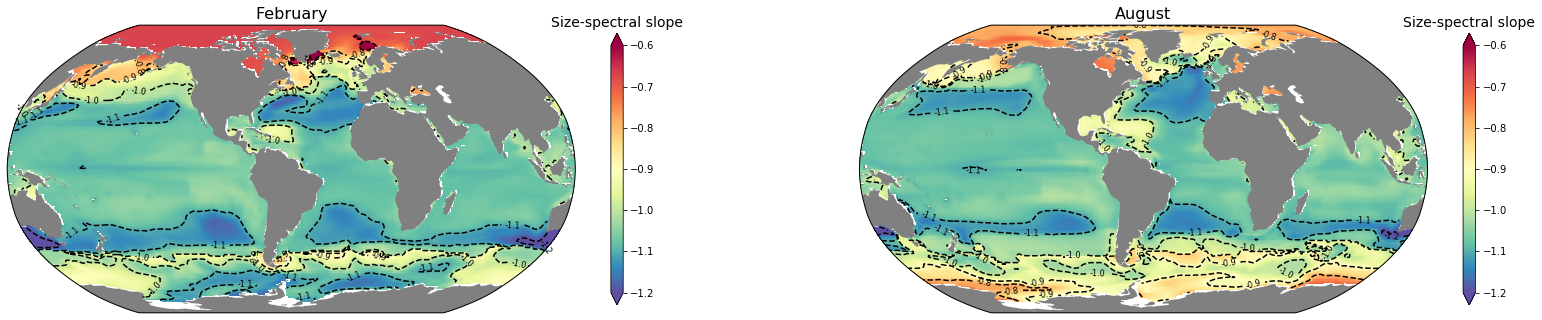

In [27]:
ypp_surface[ypp_surface==0]=np.nan

fig = plt.figure(figsize=(28, 10))
lat = ds.lat

ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(ypp_surface[1,:,:,0], coord=ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmin = -1.2, vmax = -0.6)
cs = ax.contour(lon, lat, phyto,levels = [-1.2, -1.1, -1,-0.9, -0.8, -0.6],colors='k', transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('February', fontsize =16)
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both')
cbar.ax.set_title('Size-spectral slope', fontsize = 14)

ax = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(ypp_surface[7,:,:,0], coord=ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmin = -1.2, vmax = -0.6)
cs = ax.contour(lon, lat, phyto,levels = [-1.2,-1.1, -1, -0.9, -0.8,-0.7, -0.6],colors='k', transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('August', fontsize =16)
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both')
cbar.ax.set_title('Size-spectral slope', fontsize = 14)
    
fig.savefig('SSS_Feb_Aug_surface.png', dpi=300, bbox_inches='tight')

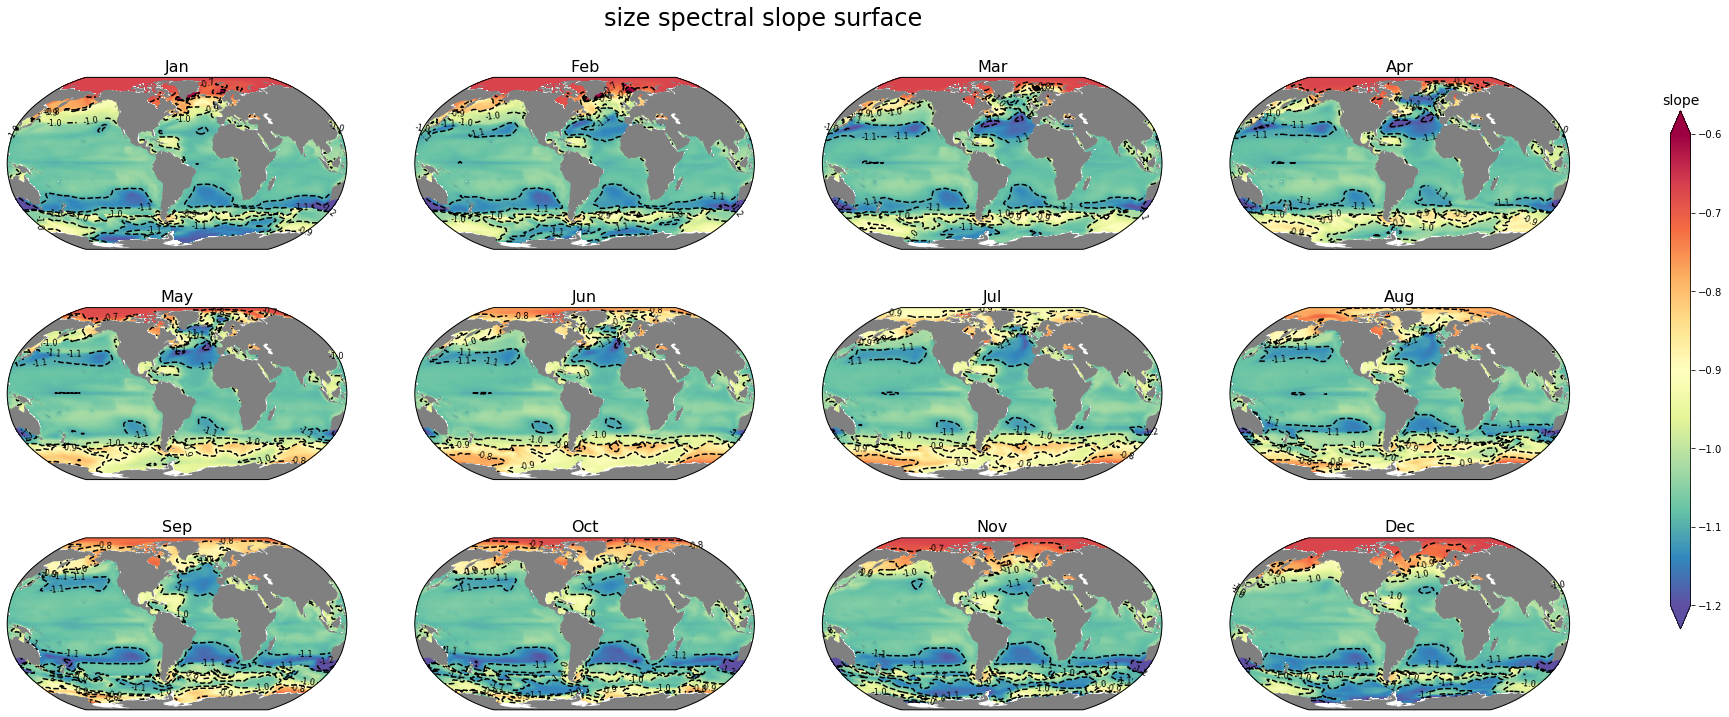

In [26]:
ypp_surface[ypp_surface==0]=np.nan

fig = plt.figure(figsize=(28, 12))
lat = ds.lat

# month names 
phyto_names = ['Jan', 'Feb','Mar','Apr',
              'May','Jun','Jul','Aug',
              'Sep','Oct','Nov','Dec']

for i in range(1,13):
    ax = fig.add_subplot(3, 4, i, projection=ccrs.Robinson(central_longitude=305.0))
    phyto, lon = add_cyclic_point(ypp_surface[i-1,:,:,0], coord=ds.lon, axis=1)
    cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmin = -1.2, vmax = -0.6)
    cs = ax.contour(lon, lat, phyto,levels = [-1.2, -1.1, -1, -0.9,-0.8, -0.7,-0.6],colors='k', transform=ccrs.PlateCarree())
    lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
    ax.set_title(''+str(phyto_names[i-1]), fontsize = 16)
    
cb_ax = fig.add_axes([0.95, 0.23, 0.01, 0.6])
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1.2, vmax=-0.6), 
                                      cmap='Spectral_r'),cax=cb_ax, extend = 'both')
cbar.ax.set_title('slope', fontsize = 14)
    
fig.suptitle('size spectral slope surface', x=0.5, y=.95,fontsize=24)
fig.savefig('SSS_monthly_surface.png', dpi=300, bbox_inches='tight')

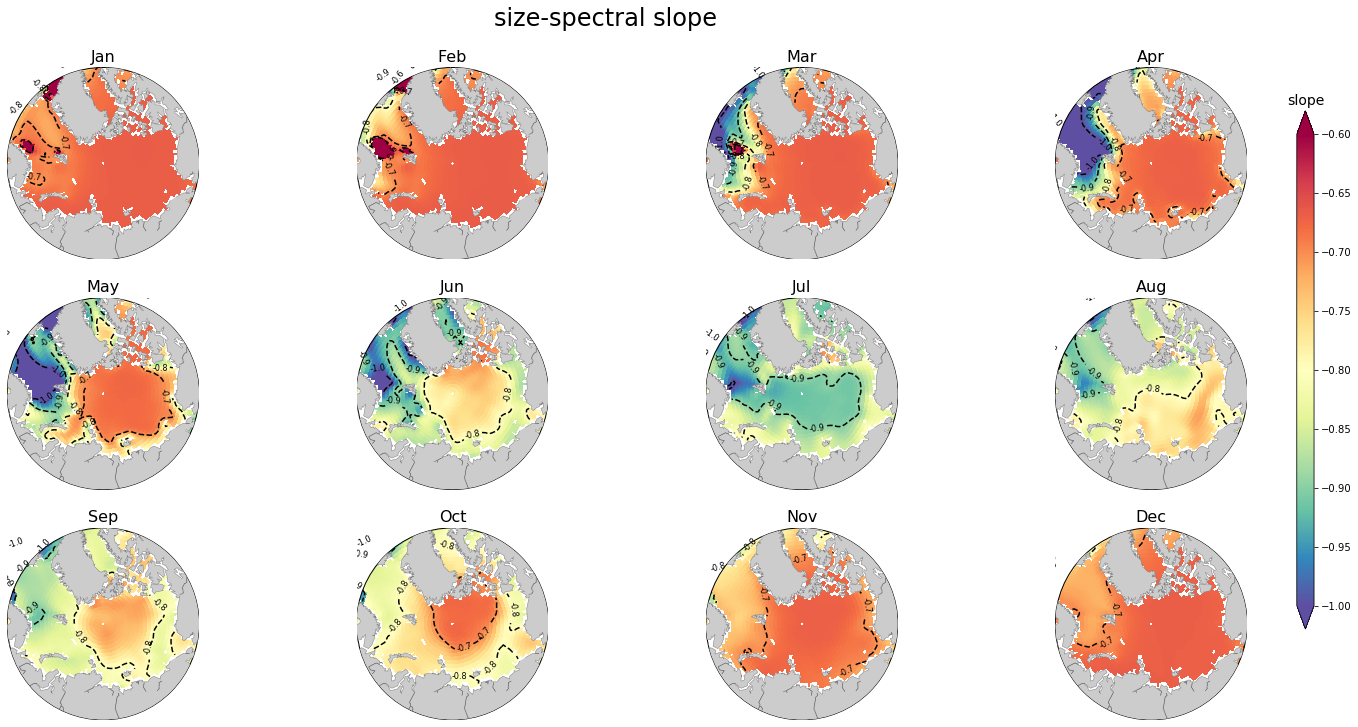

In [28]:
ypp_surface[ypp_surface==0]=np.nan

fig = plt.figure(figsize=(24, 12))
lat = ds.lat

# month names 
phyto_names = ['Jan', 'Feb','Mar','Apr',
              'May','Jun','Jul','Aug',
              'Sep','Oct','Nov','Dec']

m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
x, y = m(*np.meshgrid(ds.lon,ds.lat))

for i in range(1,13):
    ax = fig.add_subplot(3, 4, i)
    phyto, lon= add_cyclic_point(ypp_surface[i-1,:,:,0], coord=ds.lon, axis=1)
    x, y = m(*np.meshgrid(lon,ds.lat))
    cf = m.pcolor(x,y,phyto,cmap='Spectral_r', vmin = -1, vmax = -0.6)
    cs=m.contour(x, y, phyto, levels =[-1, -0.9,-0.8,-0.7, -0.6, -0.4],colors='k')
    plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
    m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
    m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
    ax.set_title(''+str(phyto_names[i-1]), fontsize = 16)
    
cb_ax = fig.add_axes([0.9, 0.23, 0.01, 0.6])
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=-0.6), 
                                      cmap='Spectral_r'),cax=cb_ax, extend = 'both')
cbar.ax.set_title('slope', fontsize = 14)
    
fig.suptitle('size-spectral slope', x=0.5, y=.95,fontsize=24)
fig.savefig('SSS_monthly_surface_ao.png', dpi=300, bbox_inches='tight')

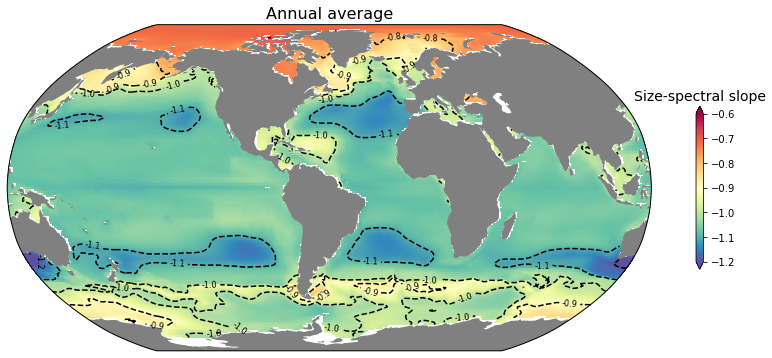

In [25]:
# this creates all zero slopes into a nan. 
ypp_surface[ypp_surface==0]=np.nan

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.nanmean(ypp_surface[:,:,:,0], axis=0), coord=ds.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmin = -1.2, vmax = -0.6)
cs = ax.contour(lon, lat, phyto,levels = [-1.2, -1.1, -1,-0.9, -0.8,-0.7, -0.6],colors='k', transform=ccrs.PlateCarree())
lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5, extend ='both')
cb.ax.set_title('Size-spectral slope', fontsize=14)
ax.set_title('Annual average', fontsize = 16);

# save the figure 
fig.savefig('size_spectral_slope_surf_annual.png', dpi=600, bbox_inches='tight')

In [12]:
import scipy.io as sio
sio.savemat('size_spectral_slope_surface.mat',{'phyto_regression_surface':ypp_surface, 
                                               'phyto_regression_100m':ypp_100m})